
Задача 4. 

In [1]:
import pandas as pd

Датасетов на русском языке не сильно много, а если и есть, то показались не очень корректными. Был выбран датасет на английском языке. 


Вообще хотелось бы обсудить варианты решения данной задачи. Одним из способов является использование wit.ai, который в том числе поддерживает русский язык. Умеет извлекать намерения, сущности из текста. То есть для быстрого создания вполне даже подойдет. Минус, что меньше возможностей для настройки по сравнению с самостояльным обучением моделей. 

Другим способом может быть использование LLaMA, но данная модель требует огромных вычислительных ресурсов для обучения, требует много размеченных данных.

Также можно использовать предобученные модели, например, ruBERT.  Трансформеры показывают в принципе высокое качество в задачах nlp, так как учитывают контекст и зависимости между словами. Однако их использование также требует значительных вычислительных ресурсов, особенно если модель нужно дообучить на специфических данных.

Учитывая ограничения по ресурсам, в качестве baseline предлагаю рассмотреть модель на основе CNN. CNN показывают довольно хорошие результаты в задачах классификации текста, особенно когда данные имеют четкую структуру. Они менее требовательны к вычислительным ресурсам по сравнению с трансформерами и могут быть эффективным решением для начального этапа.



In [3]:

train = pd.read_csv('train.csv')
train = train.drop(columns = ['Unnamed: 0', 'entity_type', 'entity_value','start_offset','end_offset','tags'])
train

,text,category
0,how can I cancel purchase 113542617735902?,cancel_order
1,can you help me canceling purchase 00004587345?,cancel_order
2,i want assistance to cancel purchase 732201349959,cancel_order
3,i want assistance to cancel order 732201349959,cancel_order
4,"I don't want my last item, help me cancel orde...",cancel_order
...,...,...
6475,I am waiting for a rebate of 299 dollars,track_refund
6476,I am waiting for a compensation of 1200 dollars,track_refund
6477,I expect a compensation of 160 dollars,track_refund
6478,I am wating for a reimbursement of $350,track_refund


Для упрощения, переведу с английского на русский с использованием модели взятую с Hugging Face. Перевод возможно будет не идеальным, но сейчас задача построить безлайн, который в дальнейшем можно улучшать. 
Для ускорения в дальнейшем буду использовать видеокарту. 

In [ ]:
import transformers
import torch
from transformers import MarianMTModel, MarianTokenizer
import tqdm

class Translator:
    def __init__(self, model_name="Helsinki-NLP/opus-mt-en-ru"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = MarianTokenizer.from_pretrained(model_name)
        self.model = MarianMTModel.from_pretrained(model_name).to(self.device)

    def translate_text(self, text):
        if pd.isnull(text):
            return text
        encoded = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(self.device)
        translated = self.model.generate(**encoded)
        return self.tokenizer.decode(translated[0], skip_special_tokens=True)

    def translate_dataframe(self, df, column_name="text"):
        df_translated = df.copy()
        for i in tqdm.tqdm(range(len(df_translated[column_name]))):
            df_translated.at[i, column_name] = self.translate_text(df_translated[column_name][i])
        return df_translated

translator = Translator()
train_translated = translator.translate_dataframe(train)

train_translated


Для достоверности и простоты категории переведем самостоятельно

In [22]:
train_translated['category'] = train['category'].replace({
    "cancel_order":"отменить_заказ",
    "change_order":"изменить_заказ",
    "change_shipping_address":"изменить_адрес_доставки",
    "check_cancellation_fee":"уточнить_стоимость_отмены",
    "check_invoice":"уточнить_по_чеку",
    "check_payment_methods":"уточнить_способ_оплаты",
    "check_refund_policy":"уточнить_политику_возврата",
    "create_account":"создать_аккаунт",
    "delete_account":"удалить_аккаунт",
    "delivery_options":"способы_доставки",
    "get_refund":"получить_возврат",
    "newsletter_subscription":"подписка_рассылку",
    "payment_issue":"проблема_при_оплате",
    "place_order":"разместить_заказ",
    "recover_password":"восстановить_пароль",
    "registration_problems":"проблема_при_регистрации",
    "review":"отзыв",
    "delivery_period":"время_доставки",
    "edit_account":"изменить аккаунт",
    "contact_human_agent":"обращение_к_оператору",
    "contact_customer_service":"обращение_к_службе_поддержки",
    "complaint":"пожаловаться",
    "set_up_shipping_address":"добавить_адрес_доставки",
    "switch_account":"сменить_аккаунт",
    "track_refund":"отследить_возврат",
    "get_invoice":"получить_чек",
    "track_order":"отследить_заказ"})

In [34]:
train_translated.to_csv("train_trans.csv", index=False, encoding="utf-8")

In [4]:
train_translated = pd.read_csv("train_trans.csv")
train_translated

,text,category
0,Как отменить покупку 113542617735902?,отменить_заказ
1,Можете ли вы помочь мне отменить покупку 00004...,отменить_заказ
2,Я хочу помочь отменить покупку 732201349959,отменить_заказ
3,Я хочу помощь отменить заказ 732201349959,отменить_заказ
4,"Я не хочу свой последний предмет, помогите мне...",отменить_заказ
...,...,...
6475,Жду скидки в 299 долларов,отследить_возврат
6476,Я жду компенсации в 1200 долларов,отследить_возврат
6477,Я ожидаю компенсации в 160 долларов,отследить_возврат
6478,Я жду возмещения в размере 350 долларов США,отследить_возврат


In [26]:
test = pd.read_csv('test.csv')
test = test.drop(columns = ['Unnamed: 0', 'entity_type', 'entity_value','start_offset','end_offset','tags'])
test

,text,category
0,I do not know how I can cancel purchase 00123842,cancel_order
1,help to cancel purchase 00004587345,cancel_order
2,cancelling purchase 00123842,cancel_order
3,cancel purchase 00004587345,cancel_order
4,I don't know how to cancel order 732201349959,cancel_order
...,...,...
805,I'm waiting for a compensation of $1200,track_refund
806,i expect a refund of 350 dollars,track_refund
807,I am waiting for a restitution of 299 dollars,track_refund
808,I am waiting for a bloody compensation of 160 ...,track_refund


In [27]:
test_translated = translator.translate_dataframe(test)
test_translated['category'] = test['category'].replace({
    "cancel_order":"отменить_заказ",
    "change_order":"изменить_заказ",
    "change_shipping_address":"изменить_адрес_доставки",
    "check_cancellation_fee":"уточнить_стоимость_отмены",
    "check_invoice":"уточнить_по_чеку",
    "check_payment_methods":"уточнить_способ_оплаты",
    "check_refund_policy":"уточнить_политику_возврата",
    "create_account":"создать_аккаунт",
    "delete_account":"удалить_аккаунт",
    "delivery_options":"способы_доставки",
    "get_refund":"получить_возврат",
    "newsletter_subscription":"подписка_рассылку",
    "payment_issue":"проблема_при_оплате",
    "place_order":"разместить_заказ",
    "recover_password":"восстановить_пароль",
    "registration_problems":"проблема_при_регистрации",
    "review":"отзыв",
    "delivery_period":"время_доставки",
    "edit_account":"изменить аккаунт",
    "contact_human_agent":"обращение_к_оператору",
    "contact_customer_service":"обращение_к_службе_поддержки",
    "complaint":"пожаловаться",
    "set_up_shipping_address":"добавить_адрес_доставки",
    "switch_account":"сменить_аккаунт",
    "track_refund":"отследить_возврат",
    "get_invoice":"получить_чек",
    "track_order":"отследить_заказ"})

100%|██████████| 810/810 [04:00<00:00,  3.36it/s]


In [ ]:
test_translated.to_csv("test_translated.csv", index=False, encoding="utf-8")

In [3]:
test_translated = pd.read_csv("test_translated.csv")
test_translated

,text,category
0,"Я не знаю, как отменить покупку 00123842",отменить_заказ
1,помощь в отмене покупки 00004587345,отменить_заказ
2,Отмена покупки 00123842,отменить_заказ
3,отменить покупку 00004587345,отменить_заказ
4,"Я не знаю, как отменить приказ 732201349959",отменить_заказ
...,...,...
805,Я жду компенсацию в размере 200 долларов.,отследить_возврат
806,Я ожидаю возмещения в 350 долларов.,отследить_возврат
807,Я жду возвращения 299 долларов.,отследить_возврат
808,Я жду чёртову компенсацию в 160 долларов.,отследить_возврат


Проверим данные на отсуствие значений

In [36]:
train_translated.isnull().sum()

text        0
category    0
dtype: int64

In [7]:
test_translated.isnull().sum()

text        0
category    0
dtype: int64

Пропуски отсуствуют

Посчитаем сколько данных у нас в каждой категории с целью определения сбалансированные классы или нет. 

In [37]:
train_translated.groupby(['category']).size()


category
восстановить_пароль             250
время_доставки                  249
добавить_адрес_доставки         235
изменить аккаунт                251
изменить_адрес_доставки         235
изменить_заказ                  252
обращение_к_оператору           241
обращение_к_службе_поддержки    231
отзыв                           232
отменить_заказ                  236
отследить_возврат               246
отследить_заказ                 241
подписка_рассылку               223
пожаловаться                    236
получить_возврат                244
получить_чек                    232
проблема_при_оплате             238
проблема_при_регистрации        229
разместить_заказ                235
сменить_аккаунт                 252
создать_аккаунт                 246
способы_доставки                238
удалить_аккаунт                 239
уточнить_по_чеку                246
уточнить_политику_возврата      229
уточнить_способ_оплаты          250
уточнить_стоимость_отмены       244
dtype: int64

In [9]:
test_translated.groupby(['category']).size()

category
восстановить_пароль             20
время_доставки                  25
добавить_адрес_доставки         32
изменить аккаунт                28
изменить_адрес_доставки         28
изменить_заказ                  21
обращение_к_оператору           36
обращение_к_службе_поддержки    41
отзыв                           32
отменить_заказ                  29
отследить_возврат               28
отследить_заказ                 27
подписка_рассылку               43
пожаловаться                    28
получить_возврат                26
получить_чек                    36
проблема_при_оплате             38
проблема_при_регистрации        36
разместить_заказ                27
сменить_аккаунт                 21
создать_аккаунт                 27
способы_доставки                28
удалить_аккаунт                 40
уточнить_по_чеку                26
уточнить_политику_возврата      40
уточнить_способ_оплаты          20
уточнить_стоимость_отмены       27
dtype: int64

Данные можно визуализировать для наглядности

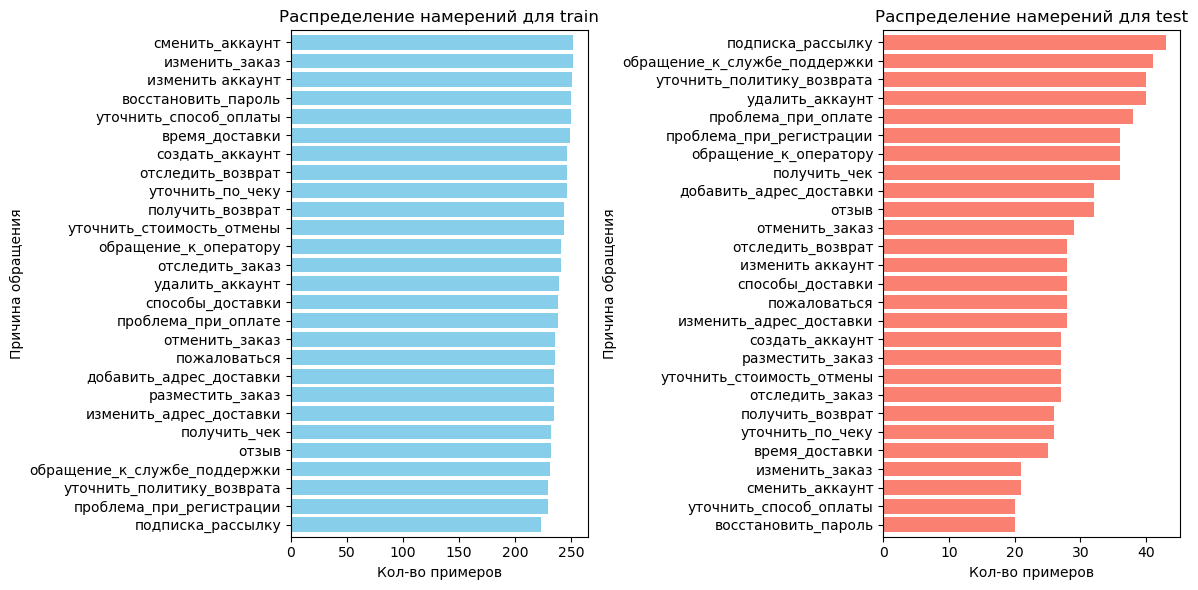

In [38]:
import matplotlib.pyplot as plt

value_counts_train = train_translated.category.value_counts()
value_counts_test = test_translated.category.value_counts()

figure, axes = plt.subplots(1, 2, figsize = (12,6))
value_counts_train.sort_values().plot(kind='barh', ax = axes[0], color = 'skyblue', width=0.8)
axes[0].set_xlabel('Кол-во примеров')
axes[0].set_ylabel('Причина обращения')
axes[0].set_title('Распределение намерений для train')

value_counts_test.sort_values().plot(kind='barh', ax = axes[1], color = 'salmon', width=0.8)
axes[1].set_xlabel('Кол-во примеров')
axes[1].set_ylabel('Причина обращения')
axes[1].set_title('Распределение намерений для test')
plt.tight_layout()
plt.show()

Для обучающей выборки количество данных примерно одинаково, что очень хорошо для процесса обучения. Нет никакого дисбаланса классов. 

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

Создадим класс для токенизации данных, используя доступный на Hugging Face. В принципе, можно было свой написать, но так как данных не сильно много, то использую готовый. 

In [7]:
class TextPreprocessor:
    def __init__(self, max_sequence_length):
        self.tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
        self.max_sequence_length = max_sequence_length
    
    def tokenize_texts(self, texts):
        encoding = self.tokenizer(
            texts,
            max_length = self.max_sequence_length,
            padding = 'max_length',
            truncation=True,
            return_tensors="pt"
        )
        return encoding["input_ids"]


Создадим класс для работы с данными, который наследуется от torch.utils.data.Dataset. 

In [8]:
class TextDataset(Dataset):
    def __init__(self, input_ids, labels):
        self.input_ids = input_ids
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.labels[idx]

Создадим класс CNN, который использует сверточные слои для извлечения признаков и полносвязные слои для классификации.

In [84]:
class TextClassifier(nn.Module):
    def __init__(self, embedding_dim, max_sequence_length, num_classes, vocab_size, dropout_rate):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = nn.Conv1d(embedding_dim, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)

        self.fc1 = nn.Linear(64*(max_sequence_length//2), 750)
        self.fc2 = nn.Linear(750, 250)
        self.fc3 = nn.Linear(250, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x.long()) #[batch_size, sequence_length, embedding_dim]
        x = x.permute(0, 2, 1) #[batch_size, embedding_dim, sequence_length]
        x = self.relu(self.conv1(x)) #[batch_size, 64, sequence_length]
        x = self.relu(self.conv2(x)) #[batch_size, 64, sequence_length]
        x = self.pool(x) #[batch_size, 64, sequence_length//2]

        x = x.view(x.size(0), -1) #[batch_size, 64*sequence_length//2]
        x = self.relu(self.fc1(x)) #[batch_size, 750]
        x = self.dropout(x) #[batch_size, 750]
        x = self.relu(self.fc2(x)) #[batch_size, 250]
        x = self.dropout(x) #[batch_size, 250]
        x = self.fc3(x) #[batch_size, 27]
        return self.softmax(x) #[batch_size, 27]

In [85]:
MAX_SEQUENCE_LENGTH = 15
preprocessor = TextPreprocessor(MAX_SEQUENCE_LENGTH)
vocab_size = preprocessor.tokenizer.vocab_size

input_ids = preprocessor.tokenize_texts(train_translated["text"].tolist())


Воспользуемся LabelEncoder для преобразования категорий в числовой формат

In [86]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(train_translated["category"].tolist())
labels

array([ 9,  9,  9, ..., 10, 10, 10])

Разделим выборку на train/valid

In [87]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(input_ids, labels, test_size=0.2, shuffle=True)

In [88]:
BATCH_SIZE = 32
train_dataset = TextDataset(x_train, y_train)
val_dataset = TextDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [89]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

dropout_rate = 0.5
EMBEDDING_DIM = 1024
NUM_CLASSES = 27
patience_scheduler = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TextClassifier(
    embedding_dim = EMBEDDING_DIM,
    max_sequence_length = MAX_SEQUENCE_LENGTH,
    num_classes = NUM_CLASSES,
    vocab_size = vocab_size,
    dropout_rate = 0.5 
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=patience_scheduler, verbose=True)


/home/kat/miniconda3/envs/env-02/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Запустим обучение, максимальное количество эпох 100, но у нас есть условие для остановки, а также есть scheduler со своим условием корректировки learning_rate. 

In [90]:
patience = 5 
best_val_accuracy = 0.0 
epochs_without_improvement = 0 
EPOCHS = 100
for epoch in tqdm.tqdm(range(EPOCHS)):
    model.train()
    train_loss = 0.0
    correct_train = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)  
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        correct_train += (outputs.argmax(1) == y_batch).sum().item()

    
    model.eval()
    val_loss = 0.0
    correct_val = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch.float())
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            correct_val += (outputs.argmax(1) == y_batch).sum().item()
    
    train_accuracy = correct_train / len(train_loader.dataset)
    val_accuracy = correct_val / len(val_loader.dataset)

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {correct_train / len(train_loader.dataset):.4f}")
    print(f"Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {correct_val / len(val_loader.dataset):.4f}")
    
    scheduler.step(val_accuracy)
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_without_improvement = 0  
        torch.save(model.state_dict(), f"best_model.pth")
        print(f"New best model saved with accuracy: {best_val_accuracy:.4f}")
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epochs.")

    
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100
Train Loss: 3.2447, Train Accuracy: 0.1026
Val Loss: 3.1437, Val Accuracy: 0.2052


  1%|          | 1/100 [00:03<05:14,  3.17s/it]

New best model saved with accuracy: 0.2052
Epoch 2/100
Train Loss: 3.0774, Train Accuracy: 0.2838
Val Loss: 2.9627, Val Accuracy: 0.3966


  2%|▏         | 2/100 [00:06<05:14,  3.21s/it]

New best model saved with accuracy: 0.3966
Epoch 3/100
Train Loss: 2.8767, Train Accuracy: 0.4913
Val Loss: 2.8006, Val Accuracy: 0.5687


  3%|▎         | 3/100 [00:09<05:09,  3.19s/it]

New best model saved with accuracy: 0.5687
Epoch 4/100
Train Loss: 2.7470, Train Accuracy: 0.6246
Val Loss: 2.6896, Val Accuracy: 0.6782


  4%|▍         | 4/100 [00:12<05:06,  3.19s/it]

New best model saved with accuracy: 0.6782
Epoch 5/100
Train Loss: 2.6648, Train Accuracy: 0.7020
Val Loss: 2.6432, Val Accuracy: 0.7168


  5%|▌         | 5/100 [00:15<05:01,  3.18s/it]

New best model saved with accuracy: 0.7168
Epoch 6/100
Train Loss: 2.6327, Train Accuracy: 0.7346
Val Loss: 2.6055, Val Accuracy: 0.7593


  6%|▌         | 6/100 [00:19<04:57,  3.16s/it]

New best model saved with accuracy: 0.7593
Epoch 7/100
Train Loss: 2.5831, Train Accuracy: 0.7824
Val Loss: 2.5439, Val Accuracy: 0.8187


  7%|▋         | 7/100 [00:22<04:54,  3.17s/it]

New best model saved with accuracy: 0.8187
Epoch 8/100
Train Loss: 2.5457, Train Accuracy: 0.8185
Val Loss: 2.5386, Val Accuracy: 0.8202


  8%|▊         | 8/100 [00:25<04:53,  3.19s/it]

New best model saved with accuracy: 0.8202
Epoch 9/100
Train Loss: 2.5341, Train Accuracy: 0.8283
Val Loss: 2.5280, Val Accuracy: 0.8326


  9%|▉         | 9/100 [00:28<04:47,  3.16s/it]

New best model saved with accuracy: 0.8326
Epoch 10/100
Train Loss: 2.5094, Train Accuracy: 0.8534
Val Loss: 2.5131, Val Accuracy: 0.8495


 10%|█         | 10/100 [00:31<04:44,  3.17s/it]

New best model saved with accuracy: 0.8495
Epoch 11/100
Train Loss: 2.4871, Train Accuracy: 0.8754
Val Loss: 2.4966, Val Accuracy: 0.8611


 11%|█         | 11/100 [00:34<04:39,  3.15s/it]

New best model saved with accuracy: 0.8611
Epoch 12/100
Train Loss: 2.4725, Train Accuracy: 0.8900
Val Loss: 2.4933, Val Accuracy: 0.8642


 12%|█▏        | 12/100 [00:37<04:35,  3.13s/it]

New best model saved with accuracy: 0.8642


 13%|█▎        | 13/100 [00:40<04:16,  2.95s/it]

Epoch 13/100
Train Loss: 2.4672, Train Accuracy: 0.8931
Val Loss: 2.5007, Val Accuracy: 0.8565
No improvement for 1 epochs.
Epoch 14/100
Train Loss: 2.4632, Train Accuracy: 0.8966
Val Loss: 2.4821, Val Accuracy: 0.8750


 14%|█▍        | 14/100 [00:43<04:18,  3.01s/it]

New best model saved with accuracy: 0.8750
Epoch 15/100
Train Loss: 2.4504, Train Accuracy: 0.9109
Val Loss: 2.4687, Val Accuracy: 0.8912


 15%|█▌        | 15/100 [00:46<04:22,  3.09s/it]

New best model saved with accuracy: 0.8912
Epoch 16/100
Train Loss: 2.4373, Train Accuracy: 0.9246
Val Loss: 2.4553, Val Accuracy: 0.9028


 16%|█▌        | 16/100 [00:50<04:23,  3.14s/it]

New best model saved with accuracy: 0.9028


 17%|█▋        | 17/100 [00:52<04:03,  2.93s/it]

Epoch 17/100
Train Loss: 2.4274, Train Accuracy: 0.9334
Val Loss: 2.4707, Val Accuracy: 0.8873
No improvement for 1 epochs.


 18%|█▊        | 18/100 [00:55<03:49,  2.79s/it]

Epoch 18/100
Train Loss: 2.4243, Train Accuracy: 0.9365
Val Loss: 2.4587, Val Accuracy: 0.8997
No improvement for 2 epochs.
Epoch 19/100
Train Loss: 2.4189, Train Accuracy: 0.9419
Val Loss: 2.4534, Val Accuracy: 0.9059


 19%|█▉        | 19/100 [00:58<03:52,  2.86s/it]

New best model saved with accuracy: 0.9059
Epoch 20/100
Train Loss: 2.4184, Train Accuracy: 0.9416
Val Loss: 2.4489, Val Accuracy: 0.9113


 20%|██        | 20/100 [01:01<03:54,  2.93s/it]

New best model saved with accuracy: 0.9113
Epoch 21/100
Train Loss: 2.4153, Train Accuracy: 0.9441
Val Loss: 2.4444, Val Accuracy: 0.9136


 21%|██        | 21/100 [01:04<03:57,  3.01s/it]

New best model saved with accuracy: 0.9136


 22%|██▏       | 22/100 [01:06<03:41,  2.84s/it]

Epoch 22/100
Train Loss: 2.4148, Train Accuracy: 0.9448
Val Loss: 2.4446, Val Accuracy: 0.9128
No improvement for 1 epochs.


 23%|██▎       | 23/100 [01:09<03:30,  2.73s/it]

Epoch 23/100
Train Loss: 2.4147, Train Accuracy: 0.9446
Val Loss: 2.4470, Val Accuracy: 0.9136
No improvement for 2 epochs.


 24%|██▍       | 24/100 [01:11<03:19,  2.63s/it]

Epoch 24/100
Train Loss: 2.4126, Train Accuracy: 0.9462
Val Loss: 2.4486, Val Accuracy: 0.9113
No improvement for 3 epochs.
Epoch 25/100
Train Loss: 2.4102, Train Accuracy: 0.9479
Val Loss: 2.4427, Val Accuracy: 0.9167


 25%|██▌       | 25/100 [01:14<03:27,  2.77s/it]

New best model saved with accuracy: 0.9167
Epoch 26/100
Train Loss: 2.4082, Train Accuracy: 0.9502
Val Loss: 2.4406, Val Accuracy: 0.9182


 26%|██▌       | 26/100 [01:17<03:31,  2.86s/it]

New best model saved with accuracy: 0.9182
Epoch 27/100
Train Loss: 2.4073, Train Accuracy: 0.9510
Val Loss: 2.4387, Val Accuracy: 0.9205


 27%|██▋       | 27/100 [01:20<03:34,  2.94s/it]

New best model saved with accuracy: 0.9205
Epoch 28/100
Train Loss: 2.4076, Train Accuracy: 0.9512
Val Loss: 2.4380, Val Accuracy: 0.9228


 28%|██▊       | 28/100 [01:24<03:35,  3.00s/it]

New best model saved with accuracy: 0.9228


 29%|██▉       | 29/100 [01:26<03:22,  2.86s/it]

Epoch 29/100
Train Loss: 2.4084, Train Accuracy: 0.9498
Val Loss: 2.4384, Val Accuracy: 0.9205
No improvement for 1 epochs.


 30%|███       | 30/100 [01:29<03:14,  2.77s/it]

Epoch 30/100
Train Loss: 2.4071, Train Accuracy: 0.9512
Val Loss: 2.4388, Val Accuracy: 0.9198
No improvement for 2 epochs.


 31%|███       | 31/100 [01:31<03:05,  2.69s/it]

Epoch 31/100
Train Loss: 2.4062, Train Accuracy: 0.9520
Val Loss: 2.4378, Val Accuracy: 0.9213
No improvement for 3 epochs.


 32%|███▏      | 32/100 [01:34<02:57,  2.62s/it]

Epoch 32/100
Train Loss: 2.4064, Train Accuracy: 0.9516
Val Loss: 2.4379, Val Accuracy: 0.9213
No improvement for 4 epochs.


 32%|███▏      | 32/100 [01:36<03:25,  3.02s/it]

Epoch 33/100
Train Loss: 2.4064, Train Accuracy: 0.9518
Val Loss: 2.4378, Val Accuracy: 0.9221
No improvement for 5 epochs.
Early stopping triggered after 33 epochs.


Точность на обучающей выборке равна 95%, на валидационной 92%

Создадим класс для предсказаний

In [95]:
class TextClassifierPredictor:
    def __init__(self, model_path, embedding_dim, max_sequence_length, num_classes, vocab_size, tokenizer, label_encoder, device):
        self.device = device
        self.tokenizer = tokenizer
        self.label_encoder = label_encoder
        self.model = TextClassifier(
            embedding_dim=EMBEDDING_DIM,
            max_sequence_length=MAX_SEQUENCE_LENGTH,
            num_classes=NUM_CLASSES,
            vocab_size=vocab_size,
            dropout_rate=0
        ).to(device)
        self.model.load_state_dict(torch.load(model_path, map_location=device))
        self.model.eval()

    def predict(self, texts, max_sequence_length, batch_size = 32):
        input_ids = self.tokenizer(
            texts,
            max_length=max_sequence_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )["input_ids"].to(self.device)

        
        dataset = torch.utils.data.TensorDataset(input_ids)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        predictions = []
        with torch.no_grad():
            for batch in dataloader:
                batch_input_ids = batch[0].to(self.device)
                outputs = self.model(batch_input_ids)
                batch_predictions = outputs.argmax(dim=1).cpu().numpy()
                predictions.extend(batch_predictions)

        predicted_labels = self.label_encoder.inverse_transform(predictions)
        return predicted_labels

In [96]:
MAX_SEQUENCE_LENGTH = 15
predictor = TextClassifierPredictor(
    model_path="best_model.pth",
    embedding_dim=EMBEDDING_DIM,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    num_classes=NUM_CLASSES,
    vocab_size=vocab_size,
    tokenizer=preprocessor.tokenizer,
    label_encoder=label_encoder,
    device=device
)


/tmp/ipykernel_2232616/1633429586.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, map_location=device))


In [97]:
test_texts = test_translated["text"].tolist()  
predicted_labels = predictor.predict(test_texts, max_sequence_length= MAX_SEQUENCE_LENGTH, batch_size=32)

results_df = pd.DataFrame({
    "text": test_texts,
    "predicted_label": predicted_labels
})

results_df.to_csv("predictions.csv", index=False, encoding="utf-8")
results_df.groupby(['predicted_label']).size()

predicted_label
восстановить_пароль             23
время_доставки                  36
изменить аккаунт                19
изменить_адрес_доставки         56
изменить_заказ                  33
обращение_к_оператору           35
обращение_к_службе_поддержки    32
отзыв                           36
отменить_заказ                  26
отследить_возврат               30
отследить_заказ                 22
подписка_рассылку               42
пожаловаться                    35
получить_возврат                17
получить_чек                    38
проблема_при_оплате             45
проблема_при_регистрации        27
разместить_заказ                31
сменить_аккаунт                 21
создать_аккаунт                 29
способы_доставки                32
удалить_аккаунт                 27
уточнить_по_чеку                33
уточнить_политику_возврата      34
уточнить_способ_оплаты          11
уточнить_стоимость_отмены       40
dtype: int64

Так как для тестовой выборки у нас были таргеты, сейчас посчитаем нашу точность.

создадим класс для построение confusion матрицы

In [120]:
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

class ConfusionMatrix:
    def __init__(self, log_dir, class_names):
        
        self.writer = SummaryWriter(log_dir)
        self.class_names = class_names
    
    def log_confusion_matrix(self, y_true, y_pred, global_step=0):

        confusion = confusion_matrix(y_true, y_pred)
        fig = self._plot_confusion_matrix(confusion)
        self.writer.add_figure("Confusion Matrix", fig, global_step=global_step)

    def _plot_confusion_matrix(self, confusion):

        fig, ax = plt.subplots(figsize=(12, 12))
        ax.imshow(confusion, cmap="Blues")
        ax.set_xticks(np.arange(len(self.class_names)))
        ax.set_yticks(np.arange(len(self.class_names)))
        ax.set_xticklabels(self.class_names, rotation=45, ha="right")
        ax.set_yticklabels(self.class_names)
        ax.set_xlabel("Predicted Labels")
        ax.set_ylabel("True Labels")
        ax.set_title("Confusion Matrix")

        for i in range(len(self.class_names)):
            for j in range(len(self.class_names)):
                ax.text(j, i, f"{confusion[i, j]:.2f}", ha="center", va="center", color="black")

        plt.tight_layout()
        return fig

    def close(self):

        self.writer.close()

In [121]:


y_classes = test_translated['category']
accuracy = accuracy_score(y_classes, results_df['predicted_label'])
precision = precision_score(y_classes, results_df['predicted_label'], average='weighted')
recall = recall_score(y_classes, results_df['predicted_label'], average='weighted')
f1 = f1_score(y_classes, results_df['predicted_label'], average='weighted')

confusion = confusion_matrix(y_classes, results_df['predicted_label'])
confusion_logger = ConfusionMatrix(log_dir="runs/confusion_matrix_example", class_names=results_df['predicted_label'].unique())

confusion_logger.log_confusion_matrix(y_classes, results_df['predicted_label'], global_step=0)
confusion_logger.close()
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("Confusion Matrix:", confusion)

/home/kat/miniconda3/envs/env-02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.7703703703703704
Precision: 0.773717663415203
Recall: 0.7703703703703704
F1-score: 0.7581484647223996
Confusion Matrix: [[17  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1
   0  0  0]
 [ 0 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0 27  0  1  0  0  0  0  0  0  1  0  0  0  0  1  0  0  2  0  0
   0  0  0]
 [ 3  0  0 16  0  1  0  0  0  0  1  0  0  2  0  0  0  0  0  1  4  0  0  0
   0  0  0]
 [ 0  0  0  0 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1  0
   0  0  0]
 [ 0  0  0  1  0 18  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0 29  1  1  0  0  0  0  0  0  0  1  0  0  0  1  1  0  0
   0  0  2]
 [ 0  8  0  0  0  0  2 29  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
   1  0  0]
 [ 0  0  0  0  0  0  0  0 28  0  0  0  1  1  0  0  0  0  0  0  1  0  0  0
   0  0  1]
 [ 0  0  0  0  0  6  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0 

Получилась такая матрица 

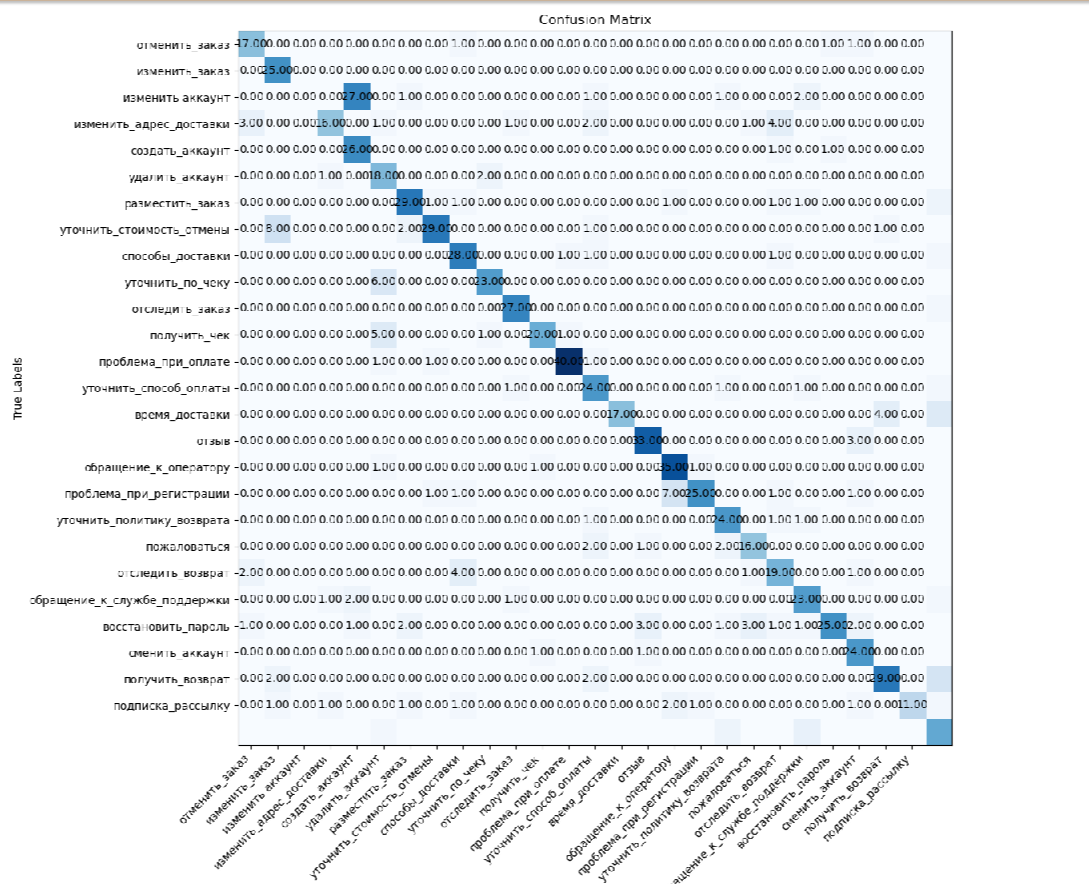

Результат даже очень не плохой по всем показателем. Да, тут есть момент, что модель один класс расспознает полностью как другой (изменить/создать аккаунт), но посмотрев на данные, а именно на качество перевода можно легко убедиться, что там порой написан бред. Следовательно, если качественно перевести данные или все же взять датасет составленный сразу на русском, то результат будет в разы лучше.



Попробуем реализовать поиск «слотов» в рамках интента 


Для данной задачи я пробовала использовать модель из Hugging Face — spacy с предобученной моделью ru_core_news_sm. Однако эта модель больше подходит для извлечения общих сущностей, таких как города, даты, имена людей и организации, что не совсем соответствует нашим специфическим слотам (например, номера заказов, суммы денег, номера чеков).

Для более точного извлечения таких слотов лучше всего подходит создание собственной модели NER (Named Entity Recognition). Однако для обучения такой модели необходимы размеченные данные, что может быть трудоемким процессом. В качестве основы для NER я бы рекомендовала использовать модели с механизмом внимания (например, BERT), так как они лучше учитывают контекст и зависимости между словами.

В качестве baseline-решения (без использования сложных моделей) можно предложить использование регулярных выражений. Этот подход прост в реализации и может быть эффективным, если слоты имеют четкую структуру (например, номера заказов, суммы денег). Однако он менее гибкий и может не справляться с более сложными или нестандартными случаями.



In [187]:
import re
class SlotExtractor:
    def __init__(self):

        pass

    def extract_order_number(self, text):

        pattern = r"\b[0-9]{6,15}\b"
        matches = re.findall(pattern, text)
        return matches[0] if matches else None

    def extract_refund_amount(self, text):

        pattern = r"\b\d{1,5}\s*(?:USD|\$)?\b"
        matches = re.findall(pattern, text)
        return matches[0] if matches else None

    def extract_receipt_number(self, text):

        pattern = r"\b\d{6,7}\s*\#?\b"
        matches = re.findall(pattern, text)
        return matches[0] if matches else None

    def apply_to_dataframe(self, df, text_column):

        df["order_number"] = df[text_column].apply(self.extract_order_number)
        df["refund_amount"] = df[text_column].apply(self.extract_refund_amount)
        df["receipt_number"] = df[text_column].apply(self.extract_receipt_number)
        
        return df

In [188]:
extractor = SlotExtractor()

result_df = extractor.apply_to_dataframe(train_translated, text_column="text")

result_df

,text,category,order_number,refund_amount,receipt_number
0,Как отменить покупку 113542617735902?,отменить_заказ,113542617735902,None,None
1,Можете ли вы помочь мне отменить покупку 00004...,отменить_заказ,00004587345,None,None
2,Я хочу помочь отменить покупку 732201349959,отменить_заказ,732201349959,None,None
3,Я хочу помощь отменить заказ 732201349959,отменить_заказ,732201349959,None,None
4,"Я не хочу свой последний предмет, помогите мне...",отменить_заказ,370795561790,None,None
...,...,...,...,...,...
6475,Жду скидки в 299 долларов,отследить_возврат,None,299,None
6476,Я жду компенсации в 1200 долларов,отследить_возврат,None,1200,None
6477,Я ожидаю компенсации в 160 долларов,отследить_возврат,None,160,None
6478,Я жду возмещения в размере 350 долларов США,отследить_возврат,None,350,None


Как видно из таблицы, извлечение с использованием регулярных выражений прошло успешно.